## Data Preprocessing

### Import Data

In [1]:
import pandas as pd
load_subreddit = "hololive"
load_num_posts = 20000
load_num_days = 180
comments_df = pd.read_csv(f'./data/{load_subreddit}_comments_{load_num_posts}_{load_num_days}.csv', delimiter=';', header=0)

In [2]:
comments_df.shape

(198277, 6)

### Data Cleaning

In [3]:
import re
import nltk
from nltk import word_tokenize

In [4]:
def clean_comment(comment, stop_words, lemmatizer):
    """
    Description:
        We clean the comment by removing comment quotes, URLS, punctuation, 
        and discarding tokens that are not alphanumeric. We don't include words which are
        stopwords in english
        
    Input:
        comment: a raw comment text string
        stop_words: a set of stop words to be eliminated
        lemmatizer: a function with a method to lemmatize text
    
    Output:
        clean_comment: an array of token representing the clean comment ready to be used in a corpus 
    """
    
    if isinstance(comment, str):
        # remove comment quotes
        comment = re.sub(r'^>(.*?)\n$', '', comment, flags=re.M)

        # replace URLs with token
        comment = re.sub(r'https*://\S*', '', comment)

        # remove punctuation
        comment = re.sub(r'[.,!?;]+', '', comment)
    else:
        return []
    
    comment_tokens = nltk.word_tokenize(comment)
    clean_comment = [ch.lower() for ch in comment_tokens 
                     if ch.isalpha() and
                     ch.lower() not in stop_words 
                     and len(ch) > 1
                    ]
    clean_comment = [lemmatizer.lemmatize(word) for word in clean_comment]
    return clean_comment

In [5]:
# Define lemmatizer and stop words
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

from gensim.parsing.preprocessing import STOPWORDS
en_stop = STOPWORDS.union(set(['like', 'savevideo']))

In [6]:
post_to_comments_dict = {}
all_comments = []
post_ids = comments_df['link_id'].unique()

for post_id in post_ids:
    comments = []
    # clean comments
    comments_raw = comments_df[comments_df['link_id'] == post_id]['body']
    for comment in comments_raw:
        comments.extend(clean_comment(comment, en_stop, wnl))
    all_comments.extend(comments)
    post_to_comments_dict[post_id] = comments
    
len(all_comments)

1446400

## Data Exploration

In [7]:
len(post_to_comments_dict.keys())

12431


Common Words:  [('stream', 11548), ('time', 9307), ('know', 8624), ('think', 8193), ('people', 8127), ('hololive', 7820), ('good', 7279), ('thing', 6414), ('got', 5714), ('want', 5425)]


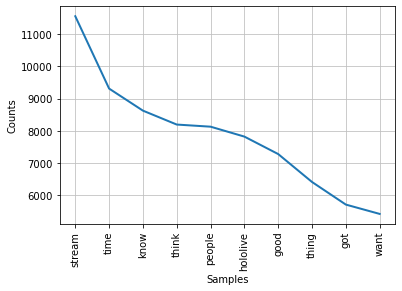

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [8]:
from nltk.probability import FreqDist
fdist = FreqDist(all_comments)
common_words = fdist.most_common(10)
print("\nCommon Words: ", common_words)
fdist.plot(10)

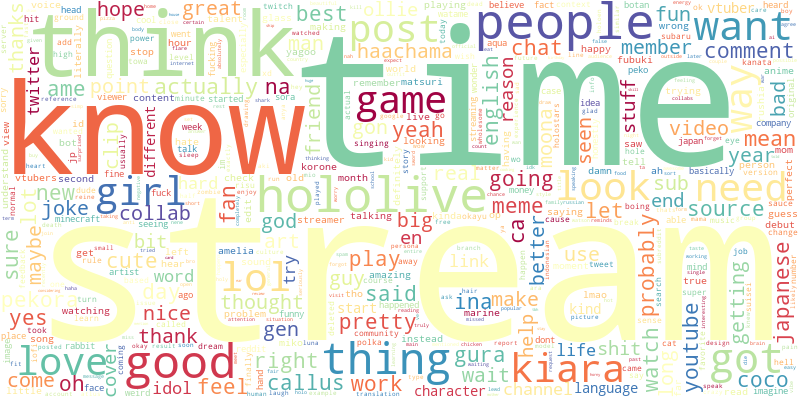

In [12]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=800, height=400, colormap="Spectral", max_words=500)
wordcloud.generate_from_frequencies(fdist)
wordcloud.to_image()

# Model 1 - Gensim LDA with BoW

Inspiration for Gensim with BoW: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

## Model Training

### Create Id to Word Dictionary

In [8]:
import gensim

In [9]:
# Create a list of post comment lists
post_to_comments_list = list(post_to_comments_dict.values())

In [15]:
dictionary = gensim.corpora.Dictionary(post_to_comments_list)

In [16]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 debut
1 hoshikawa
2 lol
3 matsurihaachama
4 matsurimp
5 saw
6 watch
7 yagoo
8 accidental
9 ah
10 ancient


### Create Bag of Words Corpus

Let's filter out terms which appear in less than 10 documents, and terms which appear in more than 50% of documents, as well as keeping only the first 100,000 most frequent tokens

In [17]:
dictionary.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)

In [18]:
bow_corpus = [dictionary.doc2bow(post) for post in post_to_comments_list]

### Train Model

In [19]:
from gensim.models import LdaMulticore

In [21]:
lda_model = LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, chunksize=100, random_state=100, workers=7)

### Save Model

In [32]:
lda_model.save("./model/lda_model_1")

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Assess Model Results

In [22]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"love" + 0.010*"good" + 0.010*"coco" + 0.009*"korone" + 0.009*"cute" + 0.009*"fubuki" + 0.008*"thank" + 0.008*"marine" + 0.007*"watame" + 0.007*"source"
Topic: 1 
Words: 0.018*"ame" + 0.015*"kiara" + 0.013*"gura" + 0.012*"ina" + 0.012*"callus" + 0.009*"time" + 0.006*"oh" + 0.006*"amelia" + 0.006*"look" + 0.005*"got"
Topic: 2 
Words: 0.042*"feedback" + 0.042*"view" + 0.040*"source" + 0.040*"search" + 0.038*"post" + 0.034*"report" + 0.034*"perfect" + 0.032*"hate" + 0.031*"help" + 0.030*"visit"
Topic: 3 
Words: 0.042*"pekora" + 0.014*"peko" + 0.009*"mom" + 0.009*"ara" + 0.009*"know" + 0.008*"moona" + 0.008*"rabbit" + 0.008*"boing" + 0.007*"mean" + 0.006*"oh"
Topic: 4 
Words: 0.023*"stream" + 0.021*"hololive" + 0.010*"collab" + 0.010*"time" + 0.010*"girl" + 0.010*"gen" + 0.008*"member" + 0.008*"idol" + 0.007*"think" + 0.007*"debut"
Topic: 5 
Words: 0.019*"game" + 0.012*"stream" + 0.011*"play" + 0.010*"youtube" + 0.007*"time" + 0.007*"think" + 0.006*"people" + 0.006*"

In [27]:
import pyLDAvis
from pyLDAvis import gensim as gensim_lda

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
LDAvis_prepared = gensim_lda.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(LDAvis_prepared, './output/lda_vis_model_1.html')

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
import matplotlib.pyplot as plt

In [20]:
def plot_top_words(model, dictionary, num_topics, title, n_top_words=10):
    assert num_topics % 2 == 0, f'num_topics={num_topics} not divisible nicely by 2'
    assert num_topics // 2 < 7, f'num_topics={num_topics} is too high and will not display well'
    
    plot_cols = num_topics // 2
    
    fig, axes = plt.subplots(2, plot_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_id in range(num_topics):
        topic_features = list()
        weights = list()
        
        for word_id, freq in model.get_topic_terms(topic_id, n_top_words):
            topic_features.append(dictionary[word_id])
            weights.append(freq)
        
        ax = axes[topic_id]
        ax.barh(topic_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_id +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


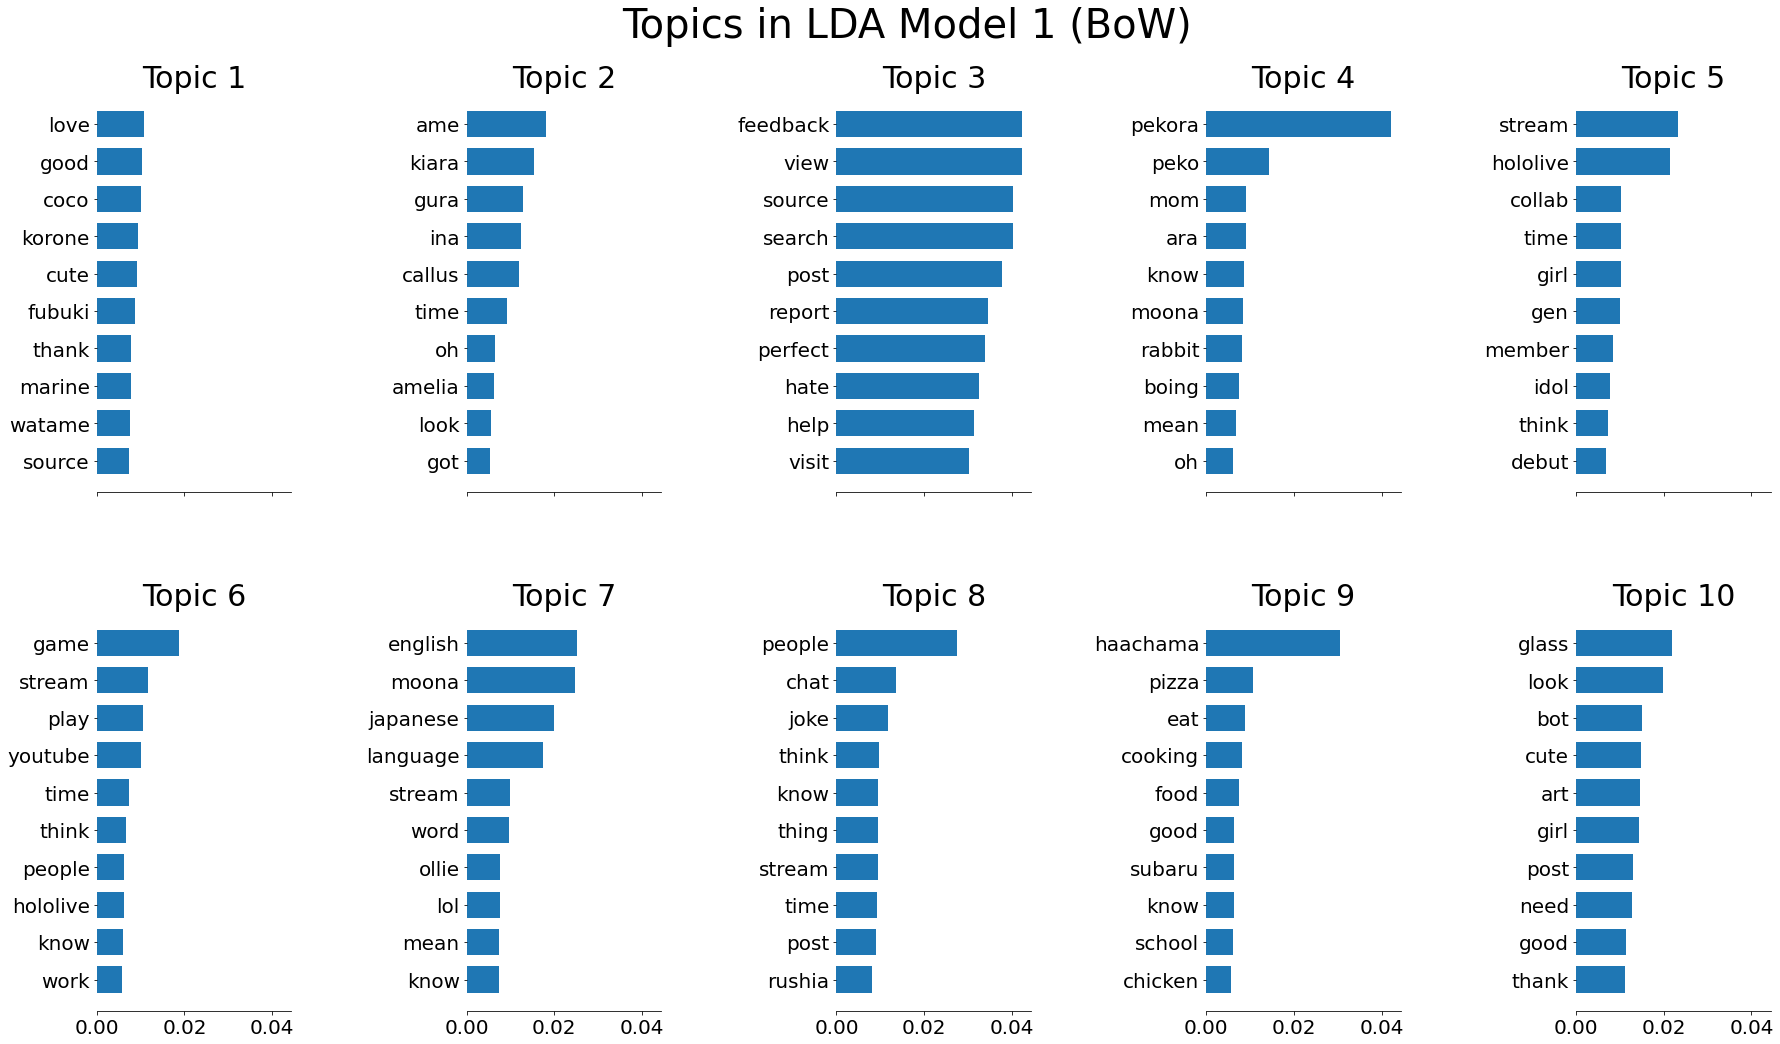

In [56]:
plot_top_words(lda_model, dictionary, 10, 'Topics in LDA Model 1 (BoW)')

In [45]:
for topic_id in range(10):
    print(f'\nTopic: {topic_id}')
    for word_id, freq in lda_model.get_topic_terms(topic_id):
        print(f'{dictionary[word_id]} - {freq}')


Topic: 0
love - 0.010798821225762367
good - 0.010270128957927227
coco - 0.010060728527605534
korone - 0.00931260734796524
cute - 0.00917813926935196
fubuki - 0.00880747102200985
thank - 0.007778243627399206
marine - 0.0077186343260109425
watame - 0.007485989481210709
source - 0.0072530475445091724

Topic: 1
ame - 0.01808343268930912
kiara - 0.015328354202210903
gura - 0.012758084572851658
ina - 0.012407217174768448
callus - 0.011958319693803787
time - 0.009242321364581585
oh - 0.0064233518205583096
amelia - 0.006239311303943396
look - 0.00551786832511425
got - 0.00541079044342041

Topic: 2
feedback - 0.04229516535997391
view - 0.04222225770354271
source - 0.04024066403508186
search - 0.04018422216176987
post - 0.037801213562488556
report - 0.034454576671123505
perfect - 0.03385571762919426
hate - 0.03247170150279999
help - 0.031358636915683746
visit - 0.030198682099580765

Topic: 3
pekora - 0.04215100035071373
peko - 0.014387484639883041
mom - 0.009000787511467934
ara - 0.008941471576

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Evaluate Results from Coherence

In [10]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=post_to_comments_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: name 'lda_model' is not defined

For the base model we get a coherence score of 0.42139

# Model 2 - LDA with TF-IDF
Inspiration: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### Train Model

In [138]:
lda_model_2 = LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10, chunksize=100, random_state=100, workers=7)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save Model

In [139]:
lda_model_2.save("./model/lda_model_2")

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


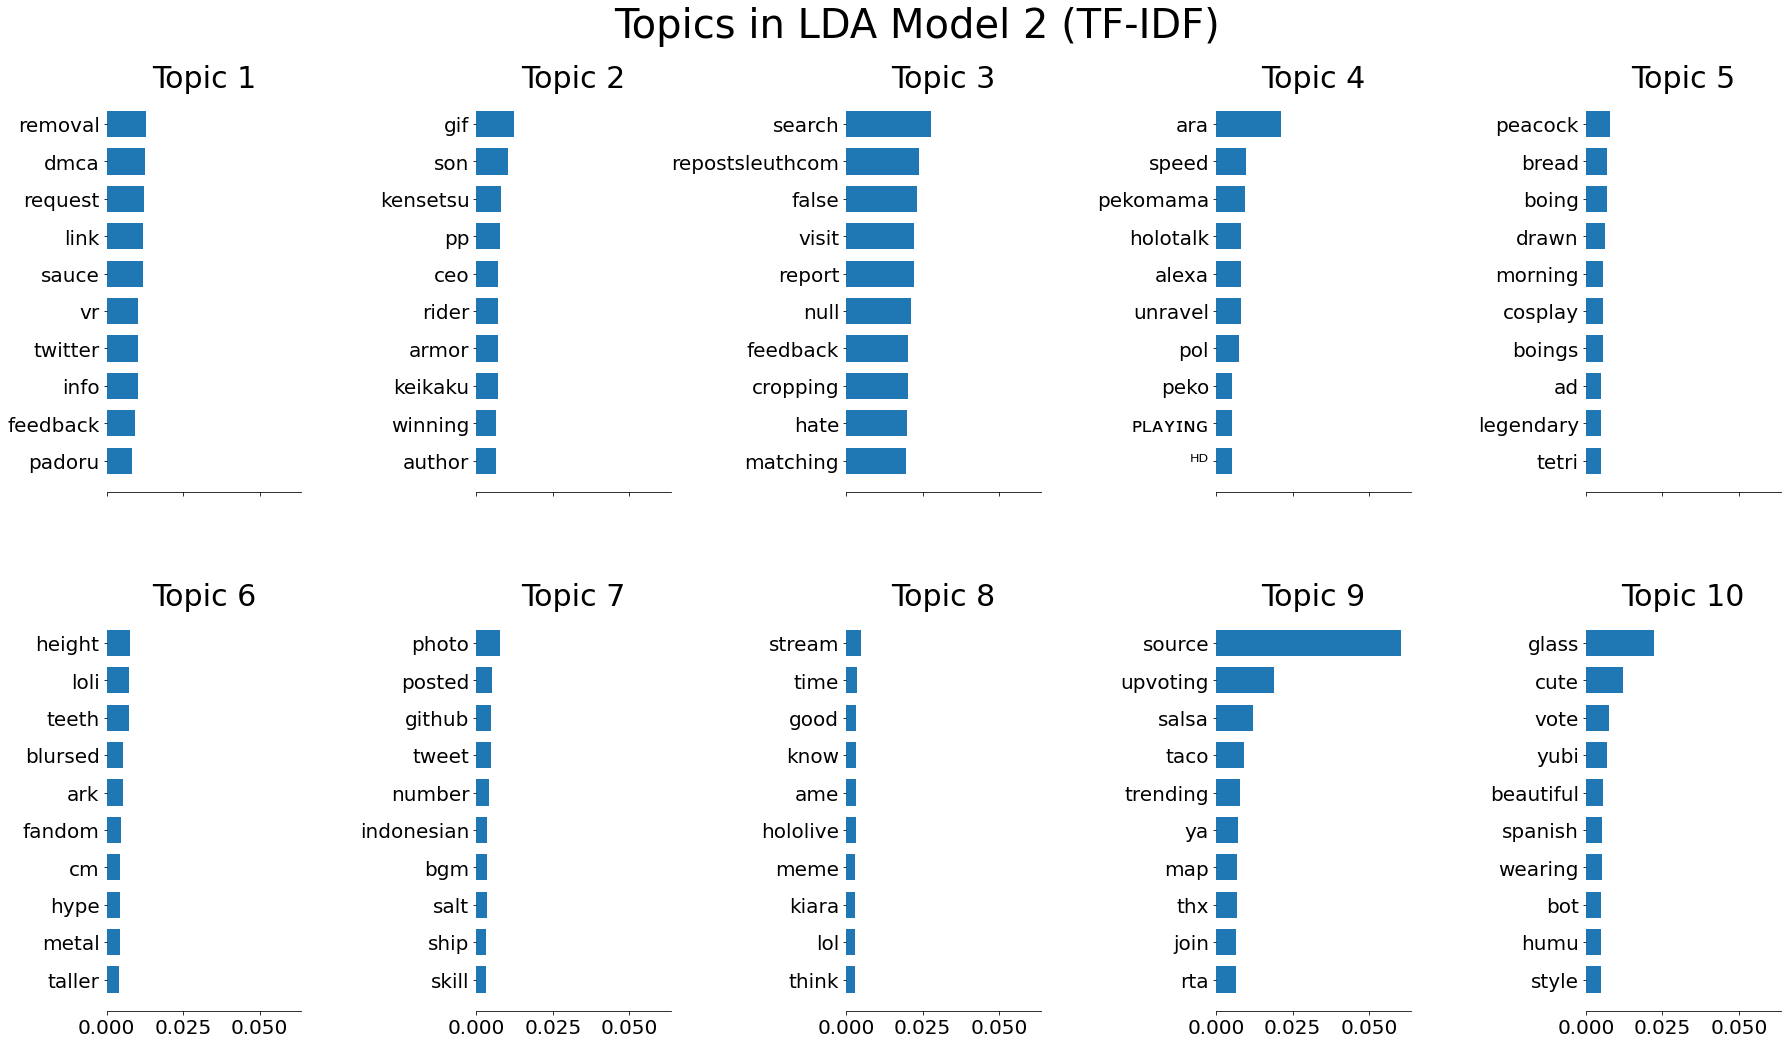

In [142]:
plot_top_words(lda_model_2, dictionary, 10, 'Topics in LDA Model 2 (TF-IDF)')

In [143]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=post_to_comments_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.453930180581562


For the base model we get a coherence score of 0.45393

# Model 3 - LDA with N-grams
Inspiration: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(post_to_comments_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[post_to_comments_list], threshold=100)

In [12]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# def functions for bigrams, trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [14]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, postag_filter=True, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        if postag_filter:
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [15]:
# Form Bigrams
data_words_bigrams = make_bigrams(post_to_comments_list)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
print(data_lemmatized[:2])

[['see'], ['procced', 'scene', 'pretty', 'funny', 'game', 'fun', 'run', 'see', 'bloodthirsty', 'vike', 'end', 'have', 'accidental', 'sex', 'worry', 'fall', 'game', 'moment', 'end', 'require', 'kill', 'order', 'ancient', 'member', 'glad', 'man', 'want', 'play', 'skyrim', 'hour', 'ecin', 'hope', 'finally', 'play', 'doom_eternal', 'dog', 'focus_commitment', 'sheer', 'fuck', 'traumatic', 'point', 'live', 'go', 'shock', 'reckon', 'engage', 'watch', 'stream', 'live', 'solid', 'minute', 'laughing', 'good', 'event', 'hit', 'hard', 'rig', 'know', 'feel', 'lifeless', 'avatar', 'hover', 'cement', 'happen', 'love']]


In [16]:
import gensim.corpora as corpora
# Create Dictionary
id2word_3 = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts_3 = data_lemmatized
# Term Document Frequency
corpus_3 = [id2word_3.doc2bow(text) for text in texts_3]

In [37]:
[id2word_3[word_id] for word_id, freq in corpus_3[2]]

['stream',
 'absolutely',
 'actually',
 'alien',
 'apologize',
 'baby',
 'certain',
 'clip',
 'fix',
 'forget',
 'original',
 'sauce',
 'source',
 'thank',
 'yeete']

### Train Model

In [157]:
lda_model_3 = gensim.models.LdaMulticore(corpus=corpus_3,
                                           id2word=id2word_3,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           workers=7)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save Model

In [159]:
lda_model_3.save("./model/lda_model_3")

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


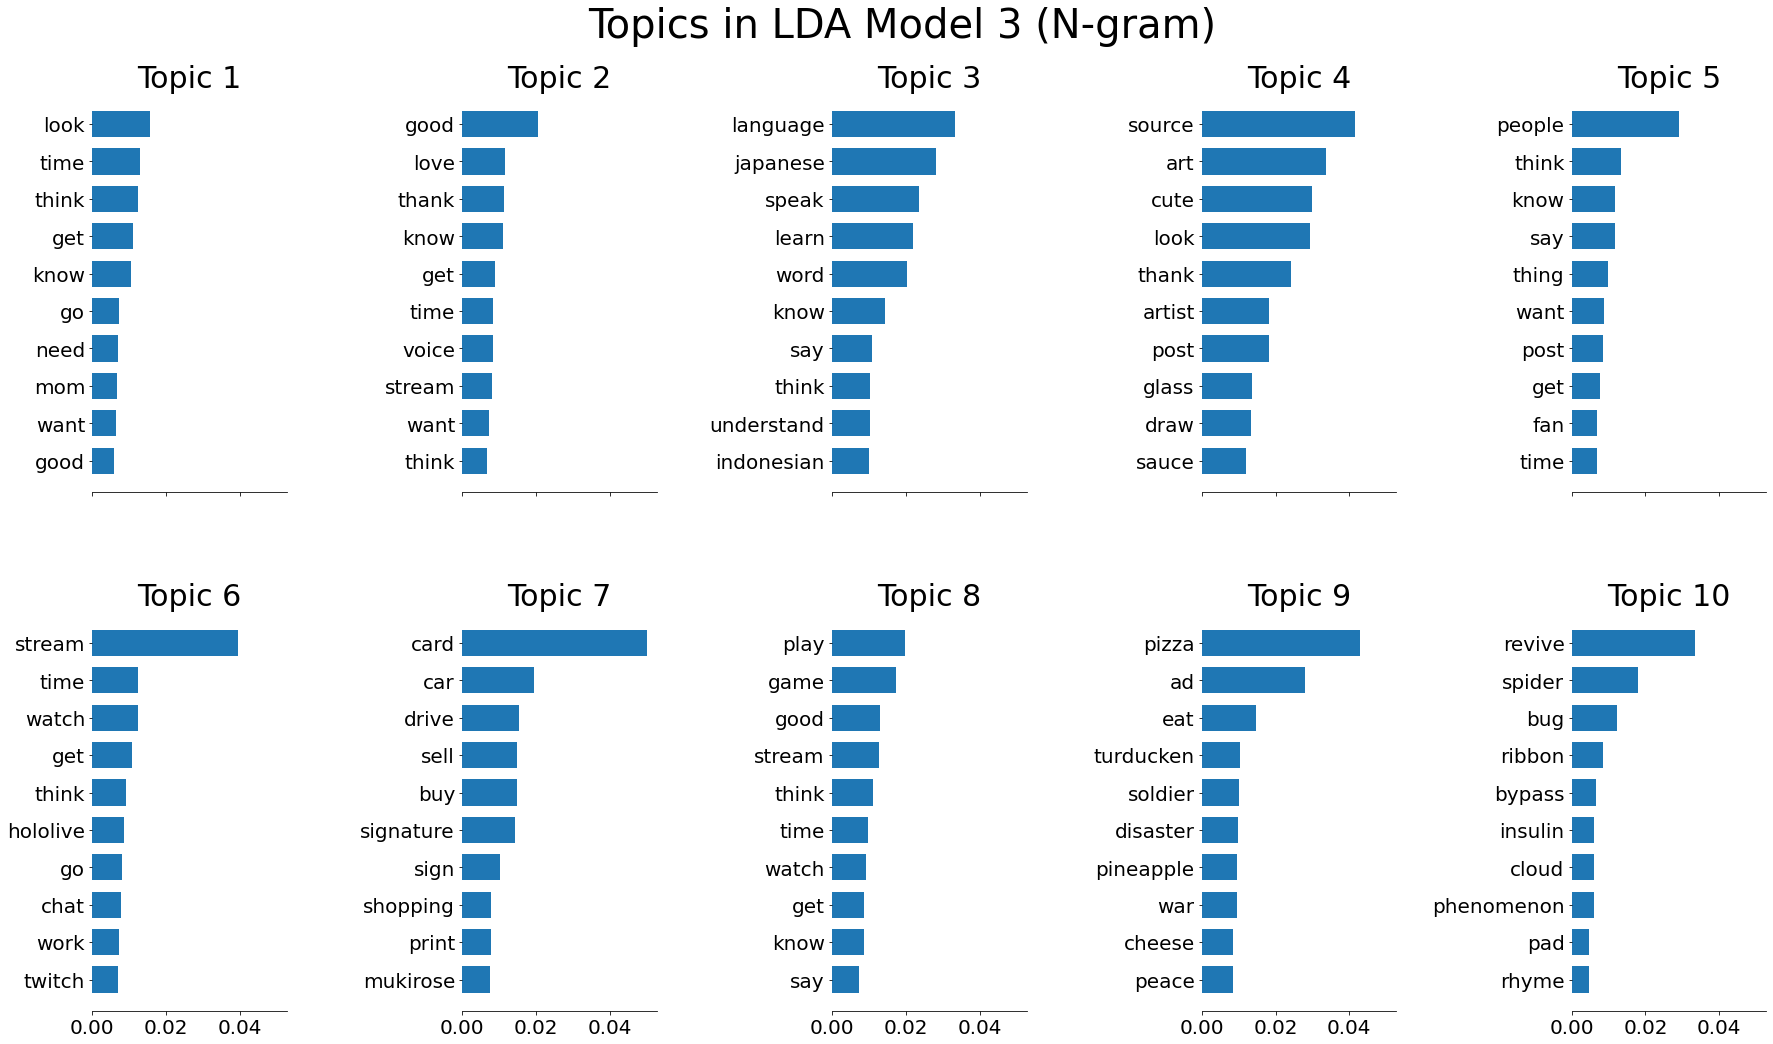

In [160]:
plot_top_words(lda_model_3, id2word_3, 10, 'Topics in LDA Model 3 (N-gram)')

In [161]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_3, texts=data_lemmatized, dictionary=id2word_3, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.3696805728306949


The inital N-gram model with POS tag filtering based on `['NOUN', 'ADJ', 'VERB', 'ADV']` resulted in the lowest coherence score so far: 0.36968. We can also see from the topics that a lot of the names of vtubers have been lost, most likely due to this POS tag filtering

## Train Model without POS filtering

In [17]:
data_lemmatized = lemmatization(data_words_bigrams, postag_filter=False)

# Create Dictionary
id2word_4 = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts_4 = data_lemmatized
# Term Document Frequency
corpus_4 = [id2word_4.doc2bow(text) for text in texts_4]

In [18]:
lda_model_4 = gensim.models.LdaMulticore(corpus=corpus_4,
                                           id2word=id2word_4,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           workers=7)

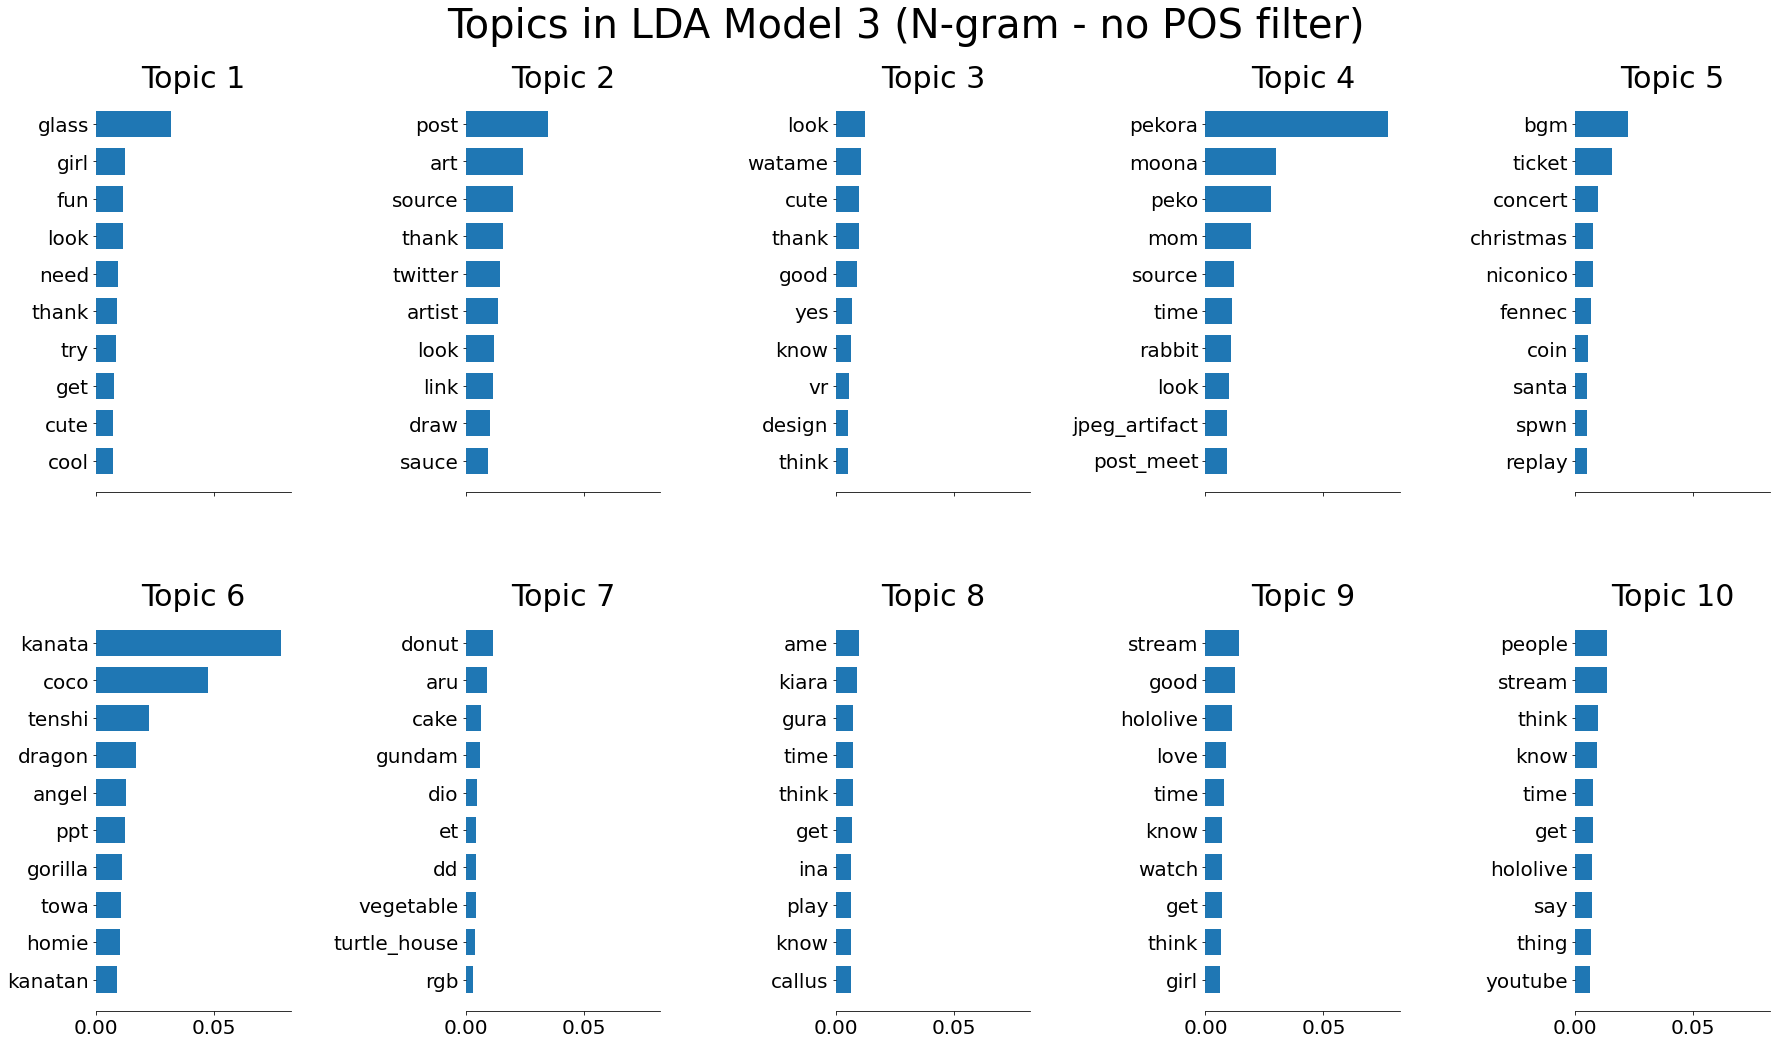

In [27]:
plot_top_words(lda_model_4, id2word_4, 10, 'Topics in LDA Model 3 (N-gram - no POS filter)')

In [24]:
coherence_model_lda = CoherenceModel(model=lda_model_4, texts=data_lemmatized, dictionary=id2word_4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43353820531443166


We get a more improved Coherence score of 0.431141 for the N-gram representation, however, looking at the topics its difficult to determine how much of an improvement this is

# Model 4 - LDA Mallet
Inspiration: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [25]:
import os
mallet_home = os.path.join('C:', os.path.sep, 'new_mallet', 'mallet-2.0.8')
print(mallet_home)
os.environ['MALLET_HOME'] = mallet_home
os.getenv('MALLET_HOME')

C:\new_mallet\mallet-2.0.8


'C:\\new_mallet\\mallet-2.0.8'

In [26]:
mallet_path = os.path.join(mallet_home, 'bin', 'mallet')
print(mallet_path)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_4, num_topics=10, id2word=id2word_4, workers=7)

C:\new_mallet\mallet-2.0.8\bin\mallet


In [29]:
def plot_top_words_mallet(model, num_topics, title, n_top_words=10):
    assert num_topics % 2 == 0, f'num_topics={num_topics} not divisible nicely by 2'
    assert num_topics // 2 < 7, f'num_topics={num_topics} is too high and will not display well'
    
    plot_cols = num_topics // 2
    
    fig, axes = plt.subplots(2, plot_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    topics_list = model.show_topics(formatted=False)
    
    for topic_id, top_words in topics_list:
        topic_features = list()
        weights = list()
        
        for word, freq in top_words:
            topic_features.append(word)
            weights.append(freq)
        
        ax = axes[topic_id]
        ax.barh(topic_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_id +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

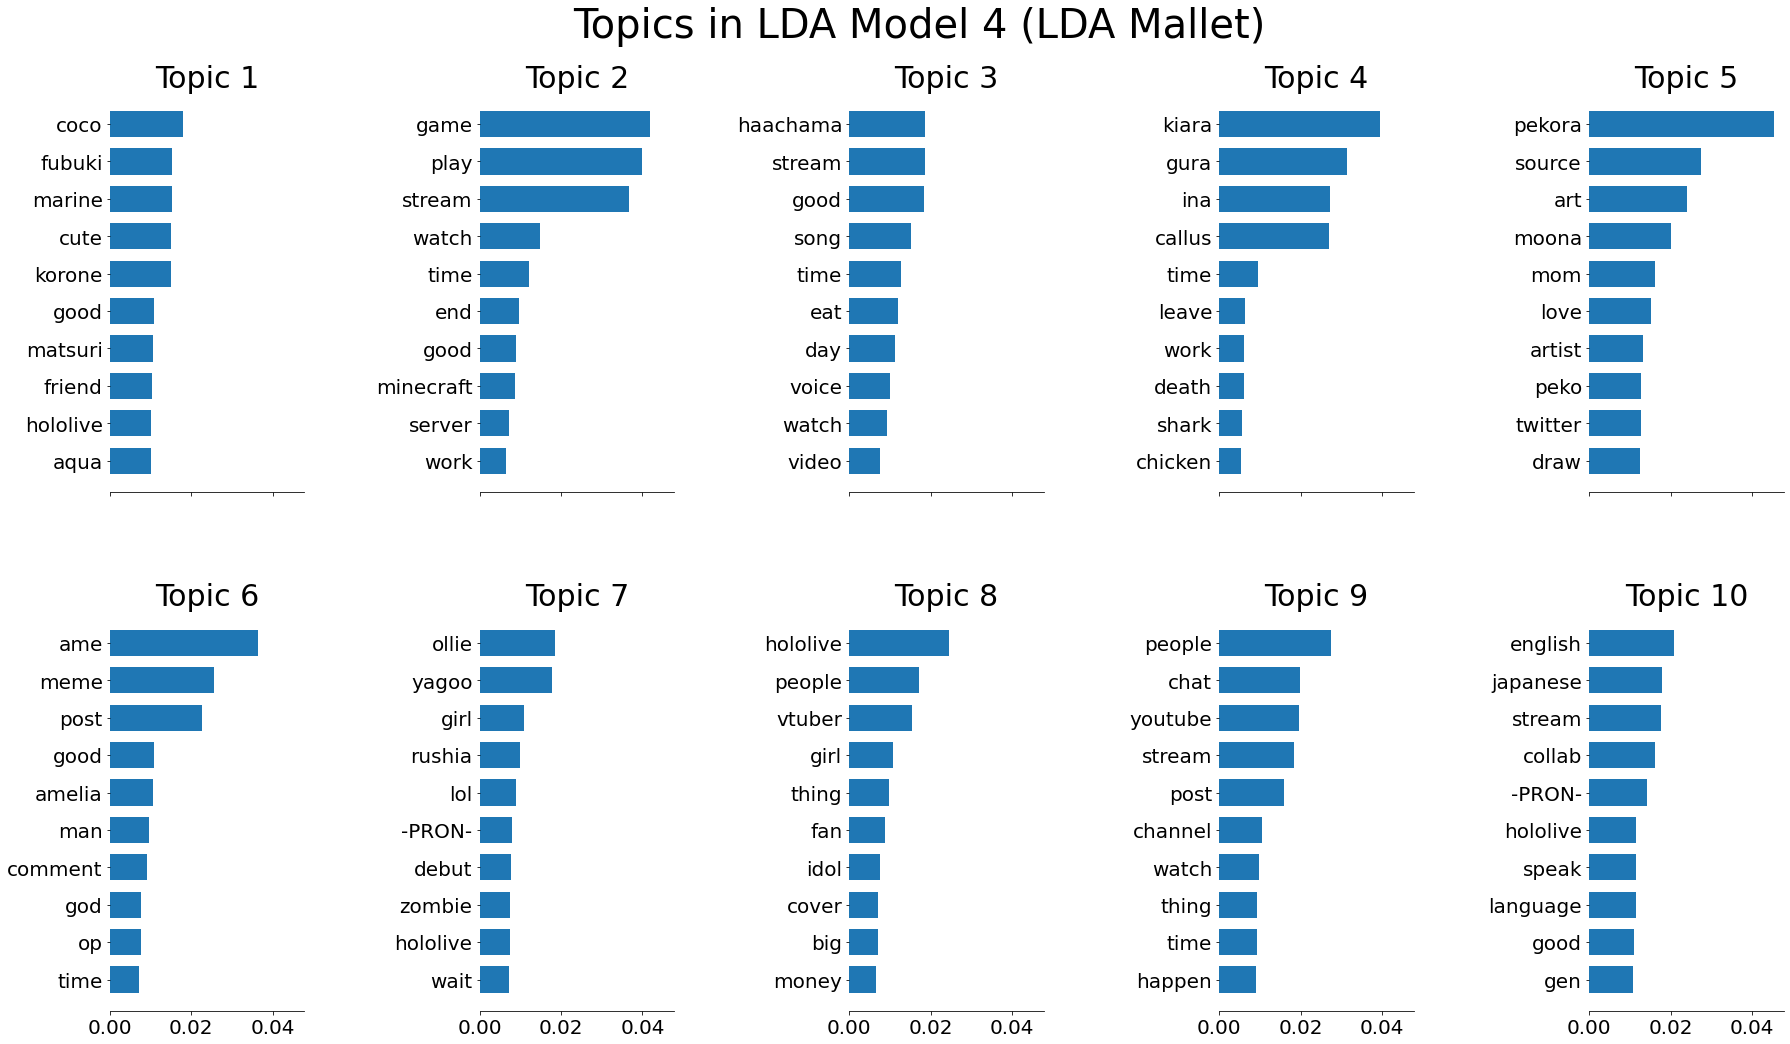

In [31]:
plot_top_words_mallet(ldamallet, 10, 'Topics in LDA Model 4 (LDA Mallet)')

In [33]:
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word_4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39308153157197756


The coherence score is 0.39308 for the LDA Mallet model, examining some of the words appearing in each of the topics we see that there is a weird token called -PRON- appearing in topics 7 and 10